This notebook follows the case study example from https://github.com/cybera/case-study-example/blob/main/EDA_ookla_dataset.ipynb

In [2]:
# Install and import modules

!pip install geopandas rtree pysal --quiet
import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
from shapely.geometry import Polygon
import os
import pysal # PySAL: python Spatial Analysis Library
import mapclassify as mc
import matplotlib.pyplot as plt
os.chdir('/content/drive/MyDrive/shared/2022-ssc-case-comp/ssc22-case-comp/sonny_dir/')
print(os.getcwd())

/content/drive/MyDrive/shared/2022-ssc-case-comp/ssc22-case-comp/sonny_dir


In [3]:
## Load data
province = 'British Columbia'
file_path = '../../dataset/'+province + '/' + province + '-speed-tiles.shp'
# print(file_path)
data = gpd.read_file(file_path)
data.head(5)

## Check if we have the right province data
print(data['PRNAME'].unique())
print(data.shape)
print(data.columns)

['British Columbia / Colombie-Britannique']
(322309, 21)
Index(['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices',
       'year', 'quarter', 'conn_type', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME',
       'DAUID', 'SACTYPE', 'DA_POP', 'PCUID', 'PCNAME', 'PCTYPE', 'PCCLASS',
       'geometry'],
      dtype='object')


In [4]:
# change the crs of our data
bc_data = data.to_crs(4326)
bc_data.head(5)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,...,CDUID,CDNAME,DAUID,SACTYPE,DA_POP,PCUID,PCNAME,PCTYPE,PCCLASS,geometry
0,0210213230223133,3415,951,29,2,2,2019,Q1,fixed,59,...,5959,Northern Rockies,59590013,6,115.0,None,None,None,None,"POLYGON ((-125.77698 59.00946, -125.77148 59.0..."
1,0210213233330210,39847,26985,22,1,1,2019,Q1,fixed,59,...,5959,Northern Rockies,59590013,6,115.0,None,None,None,None,"POLYGON ((-125.23315 58.84786, -125.22766 58.8..."
2,0210221312021113,6609,1025,33,1,1,2019,Q1,fixed,59,...,5949,Kitimat-Stikine,59490215,6,295.0,None,None,None,None,"POLYGON ((-129.99573 57.84183, -129.99023 57.8..."
3,0210221312030002,5094,1041,33,1,1,2019,Q1,fixed,59,...,5949,Kitimat-Stikine,59490215,6,295.0,None,None,None,None,"POLYGON ((-129.99023 57.84183, -129.98474 57.8..."
4,0210221312030020,11339,971,45,3,3,2019,Q1,fixed,59,...,5949,Kitimat-Stikine,59490215,6,295.0,None,None,None,None,"POLYGON ((-129.99023 57.83890, -129.98474 57.8..."


In [18]:
# Municipal boundaries data downloaded from Altails.com
# counties = gpd.read_file('../../dataset/municipal_boundaries/')
counties = gpd.read_file('../../dataset/British Columbia/ABMS_MUNI_polygon.shp')
bc_counties = counties.to_crs(4326)

# Rename column
bc_counties.rename({'AA_NAME':'GEONAME'}, axis=1, inplace=True)
bc_counties.head(5)


,AA_ID,GEONAME,ABRVN,BDY_TYPE,AA_PARENT,CHNG_ORG,UPT_TYPE,UPT_DATE,MAP_STATUS,OC_M_NMBR,OC_M_YR,OC_M_TYPE,WBST_RL,IMAGE_URL,AFCTD_AREA,AREA_SQM,LENGTH_M,SHAPE,OBEJCTID,geometry
0,119,City of Surrey,Surrey,Legal,Metro Vancouver Regional District,MCSCD,E,None,Not Appended,785,1993,OIC,None,None,None,3.647470e+08,95419.3844,None,8699.0,"POLYGON ((-122.84300 49.21988, -122.80504 49.2..."
1,124,The Corporation of the Township of Langley,Langley - District,Legal,Metro Vancouver Regional District,MCSCD,E,None,Not Appended,1831,1955,OIC,None,None,None,3.174788e+08,81966.7796,None,8704.0,"POLYGON ((-122.68014 49.00212, -122.68002 49.0..."
2,90,City of Abbotsford,Abbotsford,Legal,Fraser Valley Regional District,MCSCD,E,20150715,Not Appended,566,2008,OIC,None,None,None,3.892818e+08,111822.8968,None,8679.0,"POLYGON ((-122.46178 49.16088, -122.46197 49.1..."
3,91,City of Chilliwack,Chilliwack,Legal,Fraser Valley Regional District,MCSCD,E,20150715,Not Appended,1100,2004,OIC,None,None,None,2.930467e+08,90420.9264,None,8680.0,"POLYGON ((-121.98730 49.07857, -121.99555 49.0..."
4,111,City of Langley,Langley - City,Legal,Metro Vancouver Regional District,MCSCD,E,None,Not Appended,1830,1955,OIC,None,None,None,1.025053e+07,14286.6527,None,8691.0,"POLYGON ((-122.64150 49.08390, -122.64196 49.0..."


In [19]:
# check whether the crs of the two maps match
bc_data.crs == bc_counties.crs

True

In [20]:
# Join our data to Municipalities
data_in_bc_counties = gpd.sjoin(bc_data, bc_counties, how='inner', predicate='intersects')

# Convert kbps --> Mbps for easier reading
data_in_bc_counties['avg_d_mbps'] = data_in_bc_counties['avg_d_kbps']/1000
data_in_bc_counties['avg_u_mbps'] = data_in_bc_counties['avg_u_kbps']/1000

data_in_bc_counties['GEONAME'].unique()

array(['City of Powell River', 'Town of Comox', 'District of Sechelt',
       'City of Port Alberni', 'Town of Qualicum Beach',
       'City of Parksville', 'District of Lantzville', 'City of Nanaimo',
       'Village of Pemberton', 'Resort Municipality of Whistler',
       'District of Squamish', 'Village of Lytton', 'Town of Gibsons',
       'Village of Lions Bay', 'Bowen Island Municipality',
       'District Municipality of West Vancouver', 'Village of Anmore',
       'City of Vancouver',
       'The Corporation of the District of North Vancouver',
       'City of North Vancouver', 'City of Richmond', 'City of Delta',
       'Village of Belcarra', 'City of Port Moody', 'City of Burnaby',
       'City of Coquitlam', 'City of Port Coquitlam',
       'City of New Westminster', 'City of Surrey',
       'City of Pitt Meadows', 'City of Maple Ridge',
       'The Corporation of the Township of Langley', 'City of Mission',
       'City of Abbotsford', 'City of Langley', 'District of Hope',

In [21]:
# check columns
data_in_bc_counties.columns

Index(['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices',
       'year', 'quarter', 'conn_type', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME',
       'DAUID', 'SACTYPE', 'DA_POP', 'PCUID', 'PCNAME', 'PCTYPE', 'PCCLASS',
       'geometry', 'index_right', 'AA_ID', 'GEONAME', 'ABRVN', 'BDY_TYPE',
       'AA_PARENT', 'CHNG_ORG', 'UPT_TYPE', 'UPT_DATE', 'MAP_STATUS',
       'OC_M_NMBR', 'OC_M_YR', 'OC_M_TYPE', 'WBST_RL', 'IMAGE_URL',
       'AFCTD_AREA', 'AREA_SQM', 'LENGTH_M', 'SHAPE', 'OBEJCTID', 'avg_d_mbps',
       'avg_u_mbps'],
      dtype='object')

In [22]:
# Define w_avg()

def w_avg(df, name_col, val_cols, w_col='tests'):
    """ Computes weighted averages of specified columns"""
    '''
    df: target data frame.
    name_col: String. The grouping column.
    val_cols: list of strings. Names of the columns to average over.
    w_col: String. Name of the column that is used for weighting the averages.
    '''
    
    names = df[name_col].unique()
    col_list = [name_col, val_cols[0], val_cols[1], val_cols[2], w_col]
    result_df = pd.DataFrame(columns = col_list)    
    for name in names:
        # extract a group
        temp_table = df[df[name_col]==name] 
        # compute the weightes averages
        temp_d_avg = np.average(temp_table[val_cols[0]], weights=temp_table[w_col])
        temp_u_avg = np.average(temp_table[val_cols[1]], weights=temp_table[w_col])
        temp_l_avg = np.average(temp_table[val_cols[2]], weights=temp_table[w_col])
        temp_w = np.sum(temp_table[w_col])
        # add the averages to the result dataframe
        result_df = result_df.append(dict(zip(col_list, [name, temp_d_avg, temp_u_avg, temp_l_avg, temp_w])), ignore_index=True)
    return result_df

# test run 
test_df = data_in_bc_counties.head(10000)
w_avg(test_df, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')


,GEONAME,avg_d_mbps,avg_u_mbps,avg_lat_ms,tests
0,City of Powell River,120.597117,54.309828,15.196020,5729
1,Town of Comox,146.223497,38.295917,15.654357,8882
2,District of Sechelt,106.621750,56.888369,12.865786,5223
3,City of Port Alberni,129.246097,44.916546,15.332068,7375
4,Town of Qualicum Beach,119.039343,39.100531,14.003395,5596
5,City of Parksville,126.576361,27.745918,16.223884,8960
6,District of Lantzville,140.850307,46.769117,13.831924,2719
7,City of Nanaimo,127.451546,29.527333,13.870302,34457


In [23]:
# Obtain grouped data wtih weighted average
w_data = w_avg(data_in_bc_counties, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')
w_data

,GEONAME,avg_d_mbps,avg_u_mbps,avg_lat_ms,tests
0,City of Powell River,120.597117,54.309828,15.196020,5729
1,Town of Comox,146.223497,38.295917,15.654357,8882
2,District of Sechelt,106.621750,56.888369,12.865786,5223
3,City of Port Alberni,129.246097,44.916546,15.332068,7375
4,Town of Qualicum Beach,119.039343,39.100531,14.003395,5596
5,City of Parksville,126.576361,27.745918,16.223884,8960
6,District of Lantzville,140.850307,46.769117,13.831924,2719
7,City of Nanaimo,151.531775,50.646986,13.015616,64422
8,Village of Pemberton,99.381527,50.435302,32.971187,2013
9,Resort Municipality of Whistler,88.106574,19.717897,19.243591,21298


In [25]:
# Map for download speed in rural municipalities

# Prepare data
county_data = bc_counties[['GEONAME', 'geometry']].merge(w_data, on='GEONAME').to_crs(3401)

county_data1 = county_data.copy()
labels1 = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]
county_data['group'] = pd.cut(county_data1['avg_d_mbps'], (0, 25, 50, 100, 150, 200), right=False, labels = labels1)

county_data2 = county_data.copy()
labels2 = ["<50 Mbps", ">=50 Mbps"]
county_data2['group'] = pd.cut(county_data2['avg_d_mbps'], (0, 50, 200), right=False, labels = labels2)

county_data2.head(5)

,GEONAME,geometry,avg_d_mbps,avg_u_mbps,avg_lat_ms,tests,group
0,City of Surrey,"POLYGON ((-570633.887 5479377.709, -567868.667...",149.972681,70.200621,10.829371,532699,>=50 Mbps
1,The Corporation of the Township of Langley,"POLYGON ((-561259.180 5453989.867, -561169.374...",139.926573,40.074759,13.844815,136643,>=50 Mbps
2,City of Abbotsford,"POLYGON ((-543571.173 5470010.347, -543547.775...",141.213578,61.047675,13.030846,96448,>=50 Mbps
3,City of Chilliwack,"POLYGON ((-509879.122 5457561.540, -510480.735...",146.310747,62.599201,14.799364,61594,>=50 Mbps
4,City of Langley,"POLYGON ((-557518.497 5462779.467, -557551.623...",139.972712,53.601213,12.135503,23040,>=50 Mbps


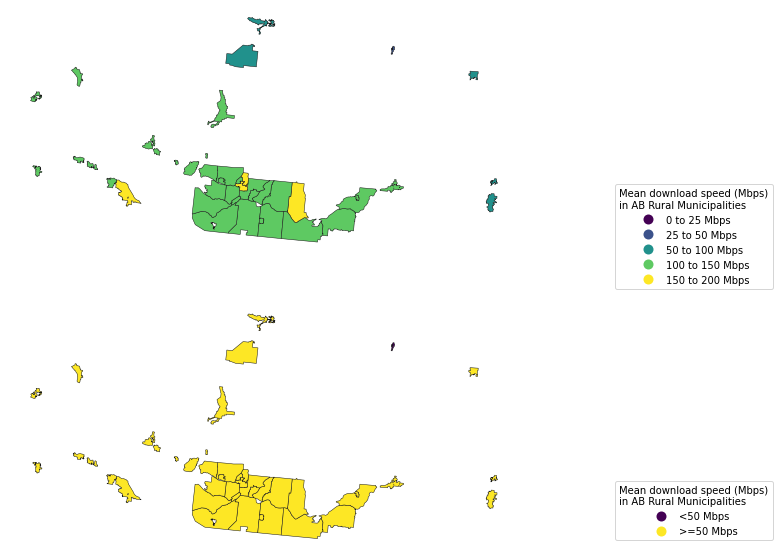

In [31]:
# produce the map for the download speed
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (25, 10))

# Detailed map
county_data.plot(column='group', cmap='viridis', linewidth=0.5, ax=ax1, edgecolor='0.1', legend=True)
ax1.axis('off')
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1.5, 0.3))
leg.set_title('Mean download speed (Mbps)\nin AB Rural Municipalities')

# Less detailed map
county_data2.plot(column='group', cmap='viridis', linewidth=0.5, ax=ax2, edgecolor='0.1', legend=True)
ax2.axis('off')
leg = ax2.get_legend()
leg.set_bbox_to_anchor((1.5, 0.3))
leg.set_title('Mean download speed (Mbps)\nin AB Rural Municipalities')
